In [1]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
import matplotlib.pyplot as plt
from common import create_transition_matrix, draw_transition_matrix, word_generator

In [2]:
names = open("./names.txt").read().splitlines()

In [3]:
empty_char_token = "."
vocab = [empty_char_token] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [4]:
x, y = [], []

for name in names:
  name_chars = [empty_char_token, *name, empty_char_token]
  for char_a, char_b in zip(name_chars, name_chars[1:]):
    x.append(vocab.index(char_a))
    y.append(vocab.index(char_b))

split = int(0.8 * len(x))
X_train, y_train, X_test, y_test = (
  Tensor(x[:split]).one_hot(vocab_size),
  Tensor(y[:split]),
  Tensor(x[split:]).one_hot(vocab_size),
  Tensor(y[split:]),
)

In [5]:
class FCNN:
  def __init__(self, input_size, output_size):
    self.linear = nn.Linear(input_size, output_size)

  def __call__(self, x: Tensor) -> Tensor:
    return self.linear(x)


fcnn = FCNN(vocab_size, vocab_size)

In [6]:
optim = nn.optim.Adam(nn.state.get_parameters(fcnn))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = fcnn(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [7]:
for step in range(1, 1501):
  loss = train_step()
  if step == 1 or step % 100 == 0:
    Tensor.training = False
    acc = (fcnn(X_test).argmax(axis=1) == y_test).mean().item()
    print(f"step {step}, loss {loss.item():.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.37, acc 3.73%
step 100, loss 3.21, acc 12.74%
step 200, loss 3.07, acc 16.47%
step 300, loss 2.96, acc 17.88%
step 400, loss 2.89, acc 17.68%
step 500, loss 2.81, acc 17.67%
step 600, loss 2.83, acc 19.00%
step 700, loss 2.80, acc 19.00%
step 800, loss 2.69, acc 19.64%
step 900, loss 2.70, acc 19.64%
step 1000, loss 2.72, acc 19.64%
step 1100, loss 2.67, acc 19.54%
step 1200, loss 2.60, acc 19.08%
step 1300, loss 2.56, acc 19.08%
step 1400, loss 2.59, acc 19.08%
step 1500, loss 2.54, acc 18.78%


In [8]:
@word_generator(
  block_size=1, empty_char=empty_char_token, max_size=float("inf")
)
def generate_word(prev_block: str):
  x = Tensor([vocab.index(prev_block)]).one_hot(vocab_size)
  y = fcnn(x).squeeze()
  counts = y.exp()
  p = counts / counts.sum()
  return np.random.choice(a=vocab, p=p.numpy())

In [9]:
generated_names = []
for _ in range(32000):
  generated_names.append(generate_word())

generated_names[:1000]

['miarkhenmogresvyne',
 'haylaea',
 'rith',
 'iumiivhre',
 'i',
 'ltycy',
 'gro',
 'tia',
 'k',
 'narcaronaniki',
 'arle',
 'sohriywmikle',
 'e',
 'mmran',
 'aihapqmowla',
 'o',
 'rttshubheloocay',
 'phn',
 'introselhxamyn',
 'sllar',
 'k',
 'islpda',
 'adan',
 'pjah',
 'nkorielyjahepuyasuzbi',
 'tre',
 'j',
 'ynn',
 'kentm',
 'kqffooluaiviollx',
 'lalacoyaidn',
 'mibkjahandlaieha',
 'in',
 'lensyorcaielywe',
 'rhaiiaymen',
 'meio',
 'a',
 'sie',
 'dradriaya',
 'pjiqwsskenasinnnia',
 'tixai',
 'a',
 'mawndincth',
 'oaelpkin',
 'tabrahllgsamiqeyn',
 'ahbi',
 'j',
 'by',
 'n',
 'rkazmelolalfwp',
 'arzsi',
 'enshveva',
 '',
 'a',
 'a',
 'kllyllylaeinanisjami',
 'niobzyarpvos',
 'lahiynathuniatraesinurblfqeldaasar',
 'psakokwa',
 'eidaraqa',
 'aivarh',
 'k',
 'min',
 '',
 'alaraleoka',
 'kyherezbini',
 'ecvaqhce',
 'gabo',
 'aocn',
 'niyeeteyayenaeuqlun',
 'larrgatayn',
 'ania',
 'alve',
 'gsjpnztylihsadq',
 'liaendgas',
 'auhsyhlzllhvchrahrsinnatagavyosokhr',
 'toaiblarrllyxier',
 'gnaham

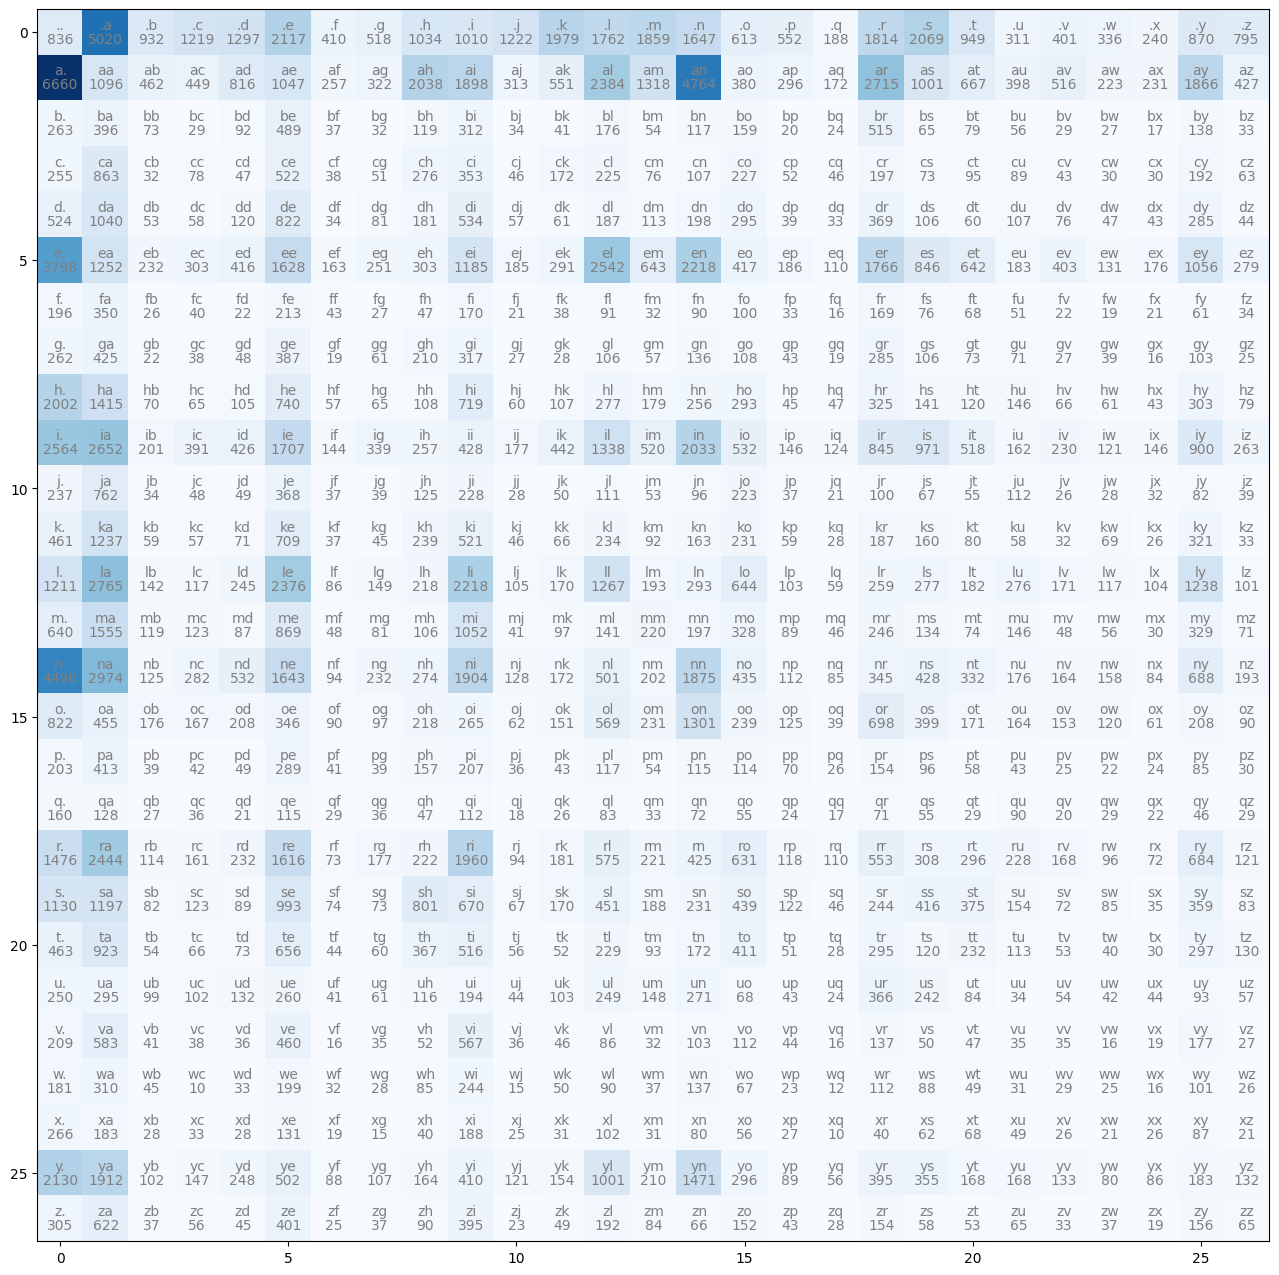

In [11]:
draw_transition_matrix(create_transition_matrix(generated_names, vocab, empty_char_token), vocab)